# Peaky Miners

In [726]:
import numpy as np 
import sklearn 
import matplotlib.pyplot as plt
import math 
import csv 
import pandas 
from sklearn import preprocessing 
import datetime as dt
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Dense
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from datetime import timedelta
from sklearn.metrics import precision_recall_fscore_support,make_scorer,fbeta_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree 

%matplotlib inline
from datetime import date

pandas.set_option('mode.chained_assignment', None)


### Importing the dataset


In [799]:
data_frame = pandas.read_csv ("./dataset/IoT_and_predictive_maintenance-full.csv",sep=";",header = 0,
                              dtype = {'machine_name': str, 'sensor_type':str,'real_value':np.float32,
                                      'units':str},parse_dates=['date_measurement','start_timestamp','end_timestamp'])
data_frame.head()


machine_name       sensor_type date_measurement         start_timestamp  \
0         FL01  drive_gear_V_eff       2017-09-02 2017-09-02 15:26:42.823   
1         FL01  drive_gear_V_eff       2017-09-02 2017-09-02 15:26:45.653   
2         FL01  drive_gear_V_eff       2017-09-02 2017-09-02 15:26:48.467   
3         FL01  drive_gear_V_eff       2017-09-02 2017-09-02 15:26:51.293   
4         FL01  drive_gear_V_eff       2017-09-02 2017-09-02 15:26:54.107   

            end_timestamp  realvalue  unit  
0 2017-09-02 15:26:42.823      0.395  mm/s  
1 2017-09-02 15:26:45.653      0.577  mm/s  
2 2017-09-02 15:26:48.467      0.717  mm/s  
3 2017-09-02 15:26:51.293      0.832  mm/s  
4 2017-09-02 15:26:54.107      0.941  mm/s

### Removal of outliers 

In [779]:

def outlier_removal(data_frame,machine_name,sensor_type) : 
    """removing outliers below Q1-1.5*IQR range for specified machine and sensor"""
    
    subset_df = data_frame.query('machine_name==@machine_name and sensor_type==@sensor_type')
    
    Q1 = subset_df['realvalue'].quantile(0.25)
    Q3 = subset_df['realvalue'].quantile(0.75)

    IQR = Q3-Q1

    indices = subset_df[subset_df.realvalue<Q1-1.5*IQR].index
    
    data_frame.drop(subset_df[subset_df.realvalue<Q1-1.5*IQR].index,inplace=True)
    
    return data_frame

sensors = data_frame.sensor_type.unique()
machines = data_frame.machine_name.unique()

print(data_frame.describe())
for m in machines : 
    for s in sensors :  
        data_frame = outlier_removal(data_frame,m,s)

print(data_frame.describe())

          realvalue
count  3.860434e+06
mean   1.221669e+03
std    1.893225e+03
min    2.000000e-03
25%    2.379000e+00
50%    7.261400e+02
75%    1.357672e+03
max    2.407599e+04
          realvalue
count  3.829213e+06
mean   1.228910e+03
std    1.896749e+03
min    2.700000e-02
25%    2.432000e+00
50%    7.332400e+02
75%    1.363608e+03
max    2.407599e+04


### Aggregating the values by hour 

Max function used between readings inside the same hour.

In [780]:
df = data_frame.copy()
df['start_timestamp'] = df['start_timestamp'].dt.floor('h')

df = df.groupby(['machine_name','sensor_type','start_timestamp','date_measurement']).max().reset_index()

df.head()

machine_name       sensor_type     start_timestamp date_measurement  \
0         FL01  drive_gear_V_eff 2017-09-02 15:00:00       2017-09-02   
1         FL01  drive_gear_V_eff 2017-09-02 18:00:00       2017-09-02   
2         FL01  drive_gear_V_eff 2017-09-06 10:00:00       2017-09-06   
3         FL01  drive_gear_V_eff 2017-09-06 12:00:00       2017-09-06   
4         FL01  drive_gear_V_eff 2017-09-06 14:00:00       2017-09-06   

            end_timestamp  realvalue  unit  
0 2017-09-02 15:27:08.217      1.258  mm/s  
1 2017-09-02 18:14:59.977      1.620  mm/s  
2 2017-09-06 10:08:59.897      1.717  mm/s  
3 2017-09-06 12:27:20.893      1.702  mm/s  
4 2017-09-06 14:38:45.523      1.880  mm/s

### Pivoting

In [781]:

pivoted_df = df.copy()
df.rename(columns = {"sensor_type" : "row_num"},inplace=True)


pivoted_df = pandas.pivot_table(df,values ='realvalue', columns = 'row_num',
                                index = ['start_timestamp','date_measurement','machine_name'])

pivoted_df.fillna(method = 'ffill',inplace=True)
pivoted_df = pivoted_df.reset_index()

pivoted_df.head()


row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01             1.258   
1       2017-09-02 18:00:00       2017-09-02         FL01             1.620   
2       2017-09-06 10:00:00       2017-09-06         FL01             1.717   
3       2017-09-06 12:00:00       2017-09-06         FL01             1.702   
4       2017-09-06 14:00:00       2017-09-06         FL01             1.880   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0                1220.734              3.110           1136.006   
1                1509.089              4.066           1238.400   
2                1332.240              4.409           1219.144   
3                1259.600              4.435           1170.005   
4                1626.001              4.429           1278.958   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                    2.513           1487.513             3.030   
1                    2.997           1467.177             3.728   
2                    3.039           1343.109             3.990   
3                    3.018           1378.971             3.980   
4                    3.058           1473.629             3.998   

row_num  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
0                2597.481               1.008             908.802   
1                2416.671               1.375             995.022   
2                2447.229               1.653            1606.433   
3                2367.403               1.601            1498.494   
4                2525.038               1.654            1809.684   

row_num  lifting_motor_V_eff  lifting_motor_a_max  
0                      1.769             1347.198  
1                      2.221             1416.080  
2                      2.421             1645.652  
3                      2.440             1558.233  
4                      2.432             1527.686

### Stadardizing the data across machines and sensors

In [782]:

pivoted_df.head()

def standardize (sensors,machines,pivoted_df):
    """Returns standardized table with each machine and sensor type standardized individually"""

    for m in machines : 
        for s in sensors : 
            scaler = preprocessing.StandardScaler()
            
            
            
            indices = pivoted_df[s][pivoted_df.machine_name == m].index
            scaled_data = scaler.fit_transform(pivoted_df[s][pivoted_df.machine_name == m ].to_numpy().reshape(-1,1))

            scaled_data.reshape(pivoted_df[s][indices].shape)
        
            scaled_data = scaled_data.reshape(scaled_data.shape[0]).tolist()
            

            pivoted_df[s][indices] = scaled_data
    return pivoted_df


sensors = data_frame.sensor_type.unique() 
machines = data_frame.machine_name.unique() 
pivoted_df.head()      
pivoted_df = standardize(sensors,machines,pivoted_df)

pivoted_df.head()


row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01         -0.925850   
1       2017-09-02 18:00:00       2017-09-02         FL01          0.097885   
2       2017-09-06 10:00:00       2017-09-06         FL01          0.372201   
3       2017-09-06 12:00:00       2017-09-06         FL01          0.329781   
4       2017-09-06 14:00:00       2017-09-06         FL01          0.833164   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0               -0.523790          -1.989768          -0.728318   
1                0.428158          -0.073943          -0.516834   
2               -0.155675           0.613429          -0.556605   
3               -0.395482           0.665533          -0.658096   
4                0.814120           0.653509          -0.433065   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                -0.002226           0.836105         -0.066029   
1                 0.575174           0.788023          0.419096   
2                 0.625279           0.494674          0.601191   
3                 0.600226           0.579467          0.594241   
4                 0.647945           0.803278          0.606751   

row_num  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
0                1.221911           -0.620993           -0.493741   
1                1.003426            0.058693           -0.404789   
2                1.040351            0.573551            0.225995   
3                0.943892            0.477246            0.114636   
4                1.134373            0.575403            0.435687   

row_num  lifting_motor_V_eff  lifting_motor_a_max  
0                  -0.242068             0.692257  
1                   0.405044             0.846321  
2                   0.691376             1.359788  
3                   0.718578             1.164264  
4                   0.707125             1.095942

### Inputing Nones for missing data

Inputing missing data as None for FL01 because significant time passed between two nearest readings.

In [783]:

start_date = dt.datetime.strptime("2018-02-03", '%Y-%m-%d')
end_date = dt.datetime.strptime("2018-09-13", '%Y-%m-%d')


date_range = end_date-start_date
missing_values = pandas.DataFrame(columns = pivoted_df.columns) 

for i in range(1,date_range.days + 1):
    
    day = start_date + timedelta(days=i)
    missing_values.loc[i-1] = [day,day,"FL01"] + [None]*(len(pivoted_df.columns)-3)


pivoted_df = pivoted_df.append(missing_values,ignore_index=True)

print(len(pivoted_df))

pivoted_df.head()

4551


row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01         -0.925850   
1       2017-09-02 18:00:00       2017-09-02         FL01          0.097885   
2       2017-09-06 10:00:00       2017-09-06         FL01          0.372201   
3       2017-09-06 12:00:00       2017-09-06         FL01          0.329781   
4       2017-09-06 14:00:00       2017-09-06         FL01          0.833164   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0               -0.523790          -1.989768          -0.728318   
1                0.428158          -0.073943          -0.516834   
2               -0.155675           0.613429          -0.556605   
3               -0.395482           0.665533          -0.658096   
4                0.814120           0.653509          -0.433065   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                -0.002226           0.836105         -0.066029   
1                 0.575174           0.788023          0.419096   
2                 0.625279           0.494674          0.601191   
3                 0.600226           0.579467          0.594241   
4                 0.647945           0.803278          0.606751   

row_num  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
0                1.221911           -0.620993           -0.493741   
1                1.003426            0.058693           -0.404789   
2                1.040351            0.573551            0.225995   
3                0.943892            0.477246            0.114636   
4                1.134373            0.575403            0.435687   

row_num  lifting_motor_V_eff  lifting_motor_a_max  
0                  -0.242068             0.692257  
1                   0.405044             0.846321  
2                   0.691376             1.359788  
3                   0.718578             1.164264  
4                   0.707125             1.095942

In [795]:
acceleration_sensors = data_frame.sensor_type.unique() 
acceleration_sensors = list(filter(lambda x : 'a_max' in x , acceleration_sensors))
pivoted_df[['start_timestamp','machine_name'] + acceleration_sensors].head()

row_num     start_timestamp machine_name  drive_gear_a_max  drive_motor_a_max  \
0       2017-09-02 15:00:00         FL01         -0.523790          -0.728318   
1       2017-09-02 18:00:00         FL01          0.428158          -0.516834   
2       2017-09-06 10:00:00         FL01         -0.155675          -0.556605   
3       2017-09-06 12:00:00         FL01         -0.395482          -0.658096   
4       2017-09-06 14:00:00         FL01          0.814120          -0.433065   

row_num  drive_wheel_a_max  idle_wheel_a_max  lifting_gear_a_max  \
0                 0.836105          1.221911           -0.493741   
1                 0.788023          1.003426           -0.404789   
2                 0.494674          1.040351            0.225995   
3                 0.579467          0.943892            0.114636   
4                 0.803278          1.134373            0.435687   

row_num  lifting_motor_a_max  
0                   0.692257  
1                   0.846321  
2                   1.359788  
3                   1.164264  
4                   1.095942

In [785]:
pivoted_df.head()

row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01         -0.925850   
1       2017-09-02 18:00:00       2017-09-02         FL01          0.097885   
2       2017-09-06 10:00:00       2017-09-06         FL01          0.372201   
3       2017-09-06 12:00:00       2017-09-06         FL01          0.329781   
4       2017-09-06 14:00:00       2017-09-06         FL01          0.833164   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0               -0.523790          -1.989768          -0.728318   
1                0.428158          -0.073943          -0.516834   
2               -0.155675           0.613429          -0.556605   
3               -0.395482           0.665533          -0.658096   
4                0.814120           0.653509          -0.433065   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                -0.002226           0.836105         -0.066029   
1                 0.575174           0.788023          0.419096   
2                 0.625279           0.494674          0.601191   
3                 0.600226           0.579467          0.594241   
4                 0.647945           0.803278          0.606751   

row_num  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
0                1.221911           -0.620993           -0.493741   
1                1.003426            0.058693           -0.404789   
2                1.040351            0.573551            0.225995   
3                0.943892            0.477246            0.114636   
4                1.134373            0.575403            0.435687   

row_num  lifting_motor_V_eff  lifting_motor_a_max  
0                  -0.242068             0.692257  
1                   0.405044             0.846321  
2                   0.691376             1.359788  
3                   0.718578             1.164264  
4                   0.707125             1.095942

### Labeling 

One week of data before the repairs were labeled. Along with the documented repairs, suspicious behaviour on machine FL05 was also labeled. 

In [788]:

dates_of_maintenance = {"FL01" : ["2018-11-13","2019-02-08","2019-02-12"], "FL02" : ["2019-04-02"],
                        "FL03" : ["2019-04-02","2019-04-05"], "FL07" : ["2019-04-02"],"FL05": ["2019-04-14","2019-05-26"]}
 
pivoted_df['label_before_maintenance'] = 0 
    
for machine in dates_of_maintenance: 
    list_of_dates = dates_of_maintenance[machine]
    
    for day in list_of_dates :
        date_format = dt.datetime.strptime(day, '%Y-%m-%d')
        
        for i in range(1,8):
            days_indicating_maintenance = date_format - dt.timedelta(days=i)
            
            pivoted_df['label_before_maintenance'][(pivoted_df.machine_name==machine) & (pivoted_df.date_measurement == days_indicating_maintenance)] = 1
    
pivoted_df[pivoted_df.label_before_maintenance == 1].describe()

row_num  drive_gear_V_eff  drive_gear_a_max  drive_motor_V_eff  \
count          160.000000        160.000000         160.000000   
mean             0.030678         -0.058342           0.266549   
std              1.122941          0.878219           1.343358   
min             -5.675078         -3.688816          -7.361313   
25%             -0.501225         -0.648826          -0.442419   
50%              0.016674          0.025049          -0.049895   
75%              0.316619          0.434480           0.803459   
max              3.240280          2.391428           5.825867   

row_num  drive_motor_a_max  drive_wheel_V_eff  drive_wheel_a_max  \
count           160.000000         160.000000         160.000000   
mean              0.323685           0.148576           0.652244   
std               1.071681           1.116013           1.538292   
min              -2.097033          -1.796459          -4.367725   
25%              -0.278147          -0.653756          -0.324155   
50%               0.016034           0.014891           0.207871   
75%               0.687870           0.669325           1.875969   
max               3.658452           2.332963           4.561834   

row_num  idle_wheel_V_eff  idle_wheel_a_max  lifting_gear_V_eff  \
count          160.000000        160.000000          160.000000   
mean             0.293179          0.762306           -0.045037   
std              1.530269          1.343597            0.900015   
min            -14.451968         -3.035581           -2.899442   
25%             -0.188949         -0.339246           -0.614048   
50%              0.251807          0.893584            0.272633   
75%              0.708051          1.583260            0.683651   
max              2.447828          4.589867            1.177436   

row_num  lifting_gear_a_max  lifting_motor_V_eff  lifting_motor_a_max  \
count            160.000000           160.000000           160.000000   
mean              -0.407138             0.001487            -0.621954   
std                0.924738             0.960884             0.862948   
min               -3.069731            -2.757337            -2.324447   
25%               -0.923861            -0.714628            -0.963356   
50%               -0.448254             0.331174            -0.845424   
75%                0.016781             0.792390            -0.197650   
max                3.289163             1.471554             2.370960   

row_num  label_before_maintenance  
count                       160.0  
mean                          1.0  
std                           0.0  
min                           1.0  
25%                           1.0  
50%                           1.0  
75%                           1.0  
max                           1.0

### Calculating moving features 

In [789]:
pivoted_df.sort_values(['start_timestamp','machine_name'],inplace=True)
pivoted_df.head()

row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01         -0.925850   
1       2017-09-02 18:00:00       2017-09-02         FL01          0.097885   
2       2017-09-06 10:00:00       2017-09-06         FL01          0.372201   
3       2017-09-06 12:00:00       2017-09-06         FL01          0.329781   
4       2017-09-06 14:00:00       2017-09-06         FL01          0.833164   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0               -0.523790          -1.989768          -0.728318   
1                0.428158          -0.073943          -0.516834   
2               -0.155675           0.613429          -0.556605   
3               -0.395482           0.665533          -0.658096   
4                0.814120           0.653509          -0.433065   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                -0.002226           0.836105         -0.066029   
1                 0.575174           0.788023          0.419096   
2                 0.625279           0.494674          0.601191   
3                 0.600226           0.579467          0.594241   
4                 0.647945           0.803278          0.606751   

row_num  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
0                1.221911           -0.620993           -0.493741   
1                1.003426            0.058693           -0.404789   
2                1.040351            0.573551            0.225995   
3                0.943892            0.477246            0.114636   
4                1.134373            0.575403            0.435687   

row_num  lifting_motor_V_eff  lifting_motor_a_max  label_before_maintenance  
0                  -0.242068             0.692257                         0  
1                   0.405044             0.846321                         0  
2                   0.691376             1.359788                         0  
3                   0.718578             1.164264                         0  
4                   0.707125             1.095942                         0

In [790]:
df_rolling_std = pandas.DataFrame(pivoted_df.copy() )
df_rolling_skew = pandas.DataFrame(pivoted_df.copy()) 
df_rolling_kurt = pandas.DataFrame(pivoted_df.copy() )
df_rolling_mean = pandas.DataFrame(pivoted_df.copy() )


 
def rolling_std(machines,sensors,df,length=10) : 
    """roling window std of specified length calculated individually for each machine sensor"""
    for m in machines : 
        for s in sensors : 
            indices = df[s][df.machine_name == m].index
         
            rolling_std = df[s][indices].rolling(length).std()
            
            df[s][indices] = rolling_std
            
    return df
def rolling_mean(machines,sensors,df,length=10) : 
    """roling window mean of specified length calculated individually for each machine sensor"""
    for m in machines : 
        for s in sensors : 
            indices = df[s][df.machine_name == m].index
         
            rolling_std = df[s][indices].rolling(length).mean()
            
            df[s][indices] = rolling_std
            
    return df

def rolling_skew(machines,sensors,df,length=10) : 
    """roling window skewness of specified length calculated individually for each machine sensor"""
    for m in machines : 
        for s in sensors : 
            indices = df[s][df.machine_name == m].index
            
            rolling_var = df[s][indices].rolling(length).skew()
            df[s][indices] = rolling_var
            
            
    return df


def rolling_kurtosis(machines,sensors,df,length=10) : 
    """roling window kurtosis of specified length calculated individually for each machine sensor"""
    for m in machines : 
        for s in sensors : 
            indices = df[s][df.machine_name == m].index
            
            rolling_kurt = df[s][indices].rolling(length).kurt()
            df[s][indices] = rolling_kurt
    return df

machines = ["FL01","FL02","FL03","FL04","FL05","FL06","FL07"]
sensors = data_frame.sensor_type.unique()


df_rolling_std = rolling_std(machines,sensors,df_rolling_std)
df_rolling_skew = rolling_skew(machines,sensors,df_rolling_skew)
df_rolling_kurt = rolling_kurtosis(machines,sensors,df_rolling_kurt)
df_rolling_mean = rolling_mean(machines,sensors,df_rolling_mean)

print(df_rolling_std.head())

row_num     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
0       2017-09-02 15:00:00       2017-09-02         FL01               NaN   
1       2017-09-02 18:00:00       2017-09-02         FL01               NaN   
2       2017-09-06 10:00:00       2017-09-06         FL01               NaN   
3       2017-09-06 12:00:00       2017-09-06         FL01               NaN   
4       2017-09-06 14:00:00       2017-09-06         FL01               NaN   

row_num  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
0                     NaN                NaN                NaN   
1                     NaN                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                     NaN                NaN                NaN   

row_num  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
0                      NaN                NaN          

In [684]:
df_rolling_skew[(df_rolling_skew.machine_name == "FL01")&(df_rolling_skew.date_measurement == "2018-09-17")]

row_no     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
951    2018-09-17 06:00:00       2018-09-17         FL01               NaN   
952    2018-09-17 14:00:00       2018-09-17         FL01          0.778988   
953    2018-09-17 22:00:00       2018-09-17         FL01          0.863888   

row_no  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
951                  NaN                NaN                NaN   
952             0.261188           0.471790           0.243398   
953             0.282750           0.495067           0.279213   

row_no  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
951                   NaN                NaN               NaN   
952              0.005013           0.156776          0.001167   
953              0.006936           0.190971          0.001283   

row_no  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
951                  NaN                 NaN                 NaN   
952             0.169065            0.007523            0.000174   
953             0.186251            0.007692            0.000143   

row_no  lifting_motor_V_eff  lifting_motor_a_max  label_before_maintenance  
951                     NaN                  NaN                         0  
952                0.004950             0.001442                         0  
953                0.004816             0.001322                         0

In [685]:
df_rolling_kurt[df_rolling_kurt.machine_name == "FL02"]

row_no     start_timestamp date_measurement machine_name  drive_gear_V_eff  \
1832   2019-03-19 14:00:00       2019-03-19         FL02               NaN   
1838   2019-03-19 21:00:00       2019-03-19         FL02               NaN   
1845   2019-03-20 05:00:00       2019-03-20         FL02               NaN   
1853   2019-03-20 13:00:00       2019-03-20         FL02               NaN   
1865   2019-03-20 17:00:00       2019-03-20         FL02               NaN   
...                    ...              ...          ...               ...   
4173   2019-07-15 06:00:00       2019-07-15         FL02         -1.225668   
4178   2019-07-15 14:00:00       2019-07-15         FL02         -1.234024   
4183   2019-07-15 22:00:00       2019-07-15         FL02         -0.403206   
4188   2019-07-16 06:00:00       2019-07-16         FL02         -0.403206   
4195   2019-07-16 14:00:00       2019-07-16         FL02         -0.507369   

row_no  drive_gear_a_max  drive_motor_V_eff  drive_motor_a_max  \
1832                 NaN                NaN                NaN   
1838                 NaN                NaN                NaN   
1845                 NaN                NaN                NaN   
1853                 NaN                NaN                NaN   
1865                 NaN                NaN                NaN   
...                  ...                ...                ...   
4173            0.053158          -0.579455           2.551972   
4178            0.199484           2.009621          -0.592891   
4183           -1.003358           1.790297          -1.100990   
4188           -1.442827           1.811396          -0.318050   
4195           -0.428203           0.668844           0.369825   

row_no  drive_wheel_V_eff  drive_wheel_a_max  idle_wheel_V_eff  \
1832                  NaN                NaN               NaN   
1838                  NaN                NaN               NaN   
1845                  NaN                NaN               NaN   
1853                  NaN                NaN               NaN   
1865                  NaN                NaN               NaN   
...                   ...                ...               ...   
4173             0.088935          -0.306917         -1.168103   
4178             3.476327           0.927157         -1.268289   
4183             3.991346           0.794021         -0.866093   
4188             3.816529           0.975057         -0.879465   
4195             7.144295           0.103293          0.098641   

row_no  idle_wheel_a_max  lifting_gear_V_eff  lifting_gear_a_max  \
1832                 NaN                 NaN                 NaN   
1838                 NaN                 NaN                 NaN   
1845                 NaN                 NaN                 NaN   
1853                 NaN                 NaN                 NaN   
1865                 NaN                 NaN                 NaN   
...                  ...                 ...                 ...   
4173            0.010978            3.195548           -1.068160   
4178            0.178012            2.641924           -1.228341   
4183            0.335100            2.641924           -1.435375   
4188            0.423019            1.847844           -1.294561   
4195           -0.452889           -0.052276           -1.540979   

row_no  lifting_motor_V_eff  lifting_motor_a_max  label_before_maintenance  
1832                    NaN                  NaN                         0  
1838                    NaN                  NaN                         0  
1845                    NaN                  NaN                         0  
1853                    NaN                  NaN                         0  
1865                    NaN                  NaN                         0  
...                     ...                  ...                       ...  
4173               0.071940            -1.287426                         0  
4178               1.185057            -1.25

In [740]:
pivoted_df[pivoted_df.label_before_maintenance == 1].describe()

row_no  drive_gear_V_eff  drive_gear_a_max  drive_motor_V_eff  \
count         160.000000        160.000000         160.000000   
mean            0.030678         -0.058342           0.266549   
std             1.122941          0.878219           1.343358   
min            -5.675078         -3.688816          -7.361313   
25%            -0.501225         -0.648826          -0.442419   
50%             0.016674          0.025049          -0.049895   
75%             0.316619          0.434480           0.803459   
max             3.240280          2.391428           5.825867   

row_no  drive_motor_a_max  drive_wheel_V_eff  drive_wheel_a_max  \
count          160.000000         160.000000         160.000000   
mean             0.323685           0.148576           0.652244   
std              1.071681           1.116013           1.538292   
min             -2.097033          -1.796459          -4.367725   
25%             -0.278147          -0.653756          -0.324155   
50%              0.016034           0.014891           0.207871   
75%              0.687870           0.669325           1.875969   
max              3.658452           2.332963           4.561834   

row_no  idle_wheel_V_eff  idle_wheel_a_max  lifting_gear_V_eff  \
count         160.000000        160.000000          160.000000   
mean            0.293179          0.762306           -0.045037   
std             1.530269          1.343597            0.900015   
min           -14.451968         -3.035581           -2.899442   
25%            -0.188949         -0.339246           -0.614048   
50%             0.251807          0.893584            0.272633   
75%             0.708051          1.583260            0.683651   
max             2.447828          4.589867            1.177436   

row_no  lifting_gear_a_max  lifting_motor_V_eff  lifting_motor_a_max  \
count           160.000000           160.000000           160.000000   
mean             -0.407138             0.001487            -0.621954   
std               0.924738             0.960884             0.862948   
min              -3.069731            -2.757337            -2.324447   
25%              -0.923861            -0.714628            -0.963356   
50%              -0.448254             0.331174            -0.845424   
75%               0.016781             0.792390            -0.197650   
max               3.289163             1.471554             2.370960   

row_no  label_before_maintenance  
count                      160.0  
mean                         1.0  
std                          0.0  
min                          1.0  
25%                          1.0  
50%                          1.0  
75%                          1.0  
max                          1.0

### Forming dataset for training

Considering only rolling features from acceleration sensors. 

In [796]:
acceleration_sensors = data_frame.sensor_type.unique() 
acceleration_sensors = list(filter(lambda x : 'a_max' in x , acceleration_sensors))
print(acceleration_sensors)

X = pandas.DataFrame() 
y = pandas.DataFrame()
label = 'label_before_maintenance'

X['label_before_maintenance'] = pivoted_df.label_before_maintenance
for sensor in acceleration_sensors : 
    
    X[sensor+'_std'] = df_rolling_std[sensor]
    X[sensor+"_skew"] = df_rolling_skew[sensor]
    X[sensor+"_kurt"] = df_rolling_kurt[sensor]
    X[sensor+"_mean"] = df_rolling_mean[sensor]

X.head()
X = X.dropna()
y['label_before_maintenance'] = X['label_before_maintenance']
X.drop('label_before_maintenance',axis=1,inplace=True)

y = y.dropna()
print("is length equal : " ,len(X)==len(y)) 
X.head()

['drive_gear_a_max', 'drive_motor_a_max', 'drive_wheel_a_max', 'idle_wheel_a_max', 'lifting_gear_a_max', 'lifting_motor_a_max']
is length equal :  True


drive_gear_a_max_std  drive_gear_a_max_skew  drive_gear_a_max_kurt  \
9               0.565126               0.517176              -0.557189   
10              0.529739               0.235735              -0.271308   
11              0.521648               0.540565               0.172963   
12              0.514251               0.412072               0.285140   
13              0.490373               0.410022               0.816942   

    drive_gear_a_max_mean  drive_motor_a_max_std  drive_motor_a_max_skew  \
9                0.059245               0.112095                0.258034   
10               0.141978               0.110556               -0.212201   
11               0.097512               0.108219                0.193355   
12               0.120632               0.111731                0.586275   
13               0.148149               0.113619                0.663146   

    drive_motor_a_max_kurt  drive_motor_a_max_mean  drive_wheel_a_max_std  \
9                -1.057549               -0.620530               0.244558   
10               -1.017425               -0.598106               0.234531   
11               -0.813751               -0.612651               0.299370   
12               -0.727638               -0.629651               0.298046   
13               -0.797708               -0.633739               0.314372   

    drive_wheel_a_max_skew  ...  idle_wheel_a_max_kurt  idle_wheel_a_max_mean  \
9                 0.329180  ...              -1.280883               1.090281   
10                0.701667  ...              -1.374941               1.095671   
11                0.897829  ...              -1.783451               1.122421   
12                0.887430  ...              -1.694550               1.146555   
13                0.433799  ...              -0.750552               1.191945   

    lifting_gear_a_max_std  lifting_gear_a_max_skew  lifting_gear_a_max_kurt  \
9                 0.774036                 0.686017                -0.435129   
10                0.705697                 0.523298                -0.599135   
11                0.634774                 0.443946                -1.428713   
12                0.628864                -0.025319                -1.641547   
13                0.563301                -0.283928                -1.069920   

    lifting_gear_a_max_mean  lifting_motor_a_max_std  \
9                  0.474644                 0.269379   
10                 0.620518                 0.245887   
11                 0.793360                 0.258360   
12                 0.913210                 0.259608   
13                 1.009486                 0.265174   

    lifting_motor_a_max_skew  lifting_motor_a_max_kurt  \
9                   0.278877                 -1.002527   
10                  0.575979                 -1.145872   
11                  0.195235                 -1.671772   
12                  0.184572                 -1.708121   
13                  0.365728                 -1.788698   

    lifting_motor_a_max_mean  
9                   1.087200  
10                  1.104339  
11                  1.171097  
12                  1.172586  
13                  1.156396  

[5 rows x 24 columns]

### Resampling SMOTE 

Resampling the data to have more positive samples. Synthetic data is constructed from 10 nearest neighbors. Samples are generated until the ratio between minority and majority class is 0.25. This means that there will be 20% of the minority class in the final dataset. 

In [743]:
smt = SMOTE (sampling_strategy = 0.25,k_neighbors = 10,random_state=42)

print(y.describe())
X_resampled, y_resampled  = smt.fit_resample(X, y)



       label_before_maintenance
count               4249.000000
mean                   0.037656
std                    0.190385
min                    0.000000
25%                    0.000000
50%                    0.000000
75%                    0.000000
max                    1.000000


In [765]:
y_resampled[y_resampled.label_before_maintenance == 1].describe()

label_before_maintenance
count                    1022.0
mean                        1.0
std                         0.0
min                         1.0
25%                         1.0
50%                         1.0
75%                         1.0
max                         1.0

In [793]:
print(len(X_resampled))
print(len(y_resampled))

5111
5111


### Simple SVM

In [800]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.4,shuffle=True,random_state=3)
model_svm = SVC()

model_svm.fit(X_train,y_train.values.ravel()) 


print("accuracy test set : " , model_svm.score(X_test,y_test.values.ravel()) )

beta=2
y_pred = model_svm.predict(X_test)
precision,recall,fscore, _ = precision_recall_fscore_support(y_test,y_pred,beta = beta,average = 'binary')

print("precision : ", precision )
print("recall : ", recall )
print("fscore beta=" + str(beta) +" : " + str(fscore))

accuracy test set :  0.9603911980440097
precision :  0.9419889502762431
recall :  0.8503740648379052
fscore beta=2 : 0.8672431332655137


### Nested Kfold 

In [ ]:
def nested_kfold_cv(clf, param_grid, X, y, k1=10, k2=3,beta=2):
    """Nested Kfold cross validation. Default 10 outer folds and 3 inner folds.
       Scoring inside the Grid Search is f score with default beta = 2.
       The function returns the scoring parameters precision, recall and f2_score and parameters
       for the best estimator in every outer fold. 
    """
    f_beta_scorer = make_scorer(fbeta_score,beta=beta)
    X= X.to_numpy()
    y = y.values.ravel()
    selection = KFold(n_splits = k1,shuffle=True,random_state=42)
    grid_selection = KFold(n_splits=k2,shuffle=True,random_state=42)
    gridsearch =GridSearchCV(clf,param_grid,cv=grid_selection)
    values = []
    parameters = []
    for train_index, test_index in selection.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        gridsearch.fit(X_train,y_train)
        
        clf = gridsearch.best_estimator_
        
        print(gridsearch.best_params_)
        precision,recall,fscore, _ = precision_recall_fscore_support(y_test,clf.predict(X_test),beta = beta,average = 'binary')
        values.append((precision,recall,fscore))
        parameters.append(gridsearch.best_params_)
    return values,parameters

### SVM 

In [745]:


model_svm = SVC()
parameters = [
              {'kernel':['rbf'], 'C':[2**i for i in range(-5,6)],'gamma': [2**i for i in range(-5,6)] }]
values,parameters = nested_kfold_cv(model_svm,parameters,X_resampled,y_resampled,k1=10,k2=3)

{'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 16, 'gamma': 0.0625, 'kernel': 'rbf'}
{'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 16, 'gamma': 0.125, 'kernel': 'rbf'}


In [746]:
print(values) 
print(parameters)

[(0.99, 0.99, 0.99), (0.990909090909091, 0.9646017699115044, 0.9697508896797152), (0.990990990990991, 1.0, 0.998185117967332), (0.9900990099009901, 0.9803921568627451, 0.9823182711198428), (1.0, 0.9811320754716981, 0.9848484848484849), (1.0, 0.9894736842105263, 0.9915611814345991), (0.9907407407407407, 1.0, 0.9981343283582089), (0.9876543209876543, 0.9876543209876543, 0.9876543209876543), (0.9904761904761905, 1.0, 0.998080614203455), (0.9903846153846154, 0.9903846153846154, 0.9903846153846154)]
[{'C': 2, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 16, 'gamma': 0.0625, 'kernel': 'rbf'}, {'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 4, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 8, 'gamma': 0.125, 'kernel': 'rbf'}, {'C': 16, 'gamma': 0.125, 'kernel': 'rbf'}]


### Decision Tree

In [761]:
clf = DecisionTreeClassifier() 


parameters = [{'criterion' : ["gini","entropy"], 'max_depth' : [2**i for i in range(1,8)],
               'max_features' : ["sqrt","log2"],'min_samples_split' : [2,5,10],'random_state': [42]}]
values,parameters = nested_kfold_cv(clf,parameters,X_resampled,y_resampled,k1=10,k2=3)

{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'criterion': 'gini', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}
{'criterion': 'gini', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}
{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}
{'criterion'

[(0.9375, 0.9, 0.907258064516129), (0.9380530973451328, 0.9380530973451328, 0.9380530973451328), (0.9181818181818182, 0.9181818181818182, 0.9181818181818182), (0.8785046728971962, 0.9215686274509803, 0.9126213592233009), (0.95, 0.8962264150943396, 0.9064885496183206), (0.9166666666666666, 0.9263157894736842, 0.9243697478991597), (0.9017857142857143, 0.9439252336448598, 0.9351851851851852), (0.8461538461538461, 0.9506172839506173, 0.9277108433734939), (0.9696969696969697, 0.9230769230769231, 0.9320388349514563), (0.9157894736842105, 0.8365384615384616, 0.8512720156555772)]
[{'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}, {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 10, 'random_state': 42}, {'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}, {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split'

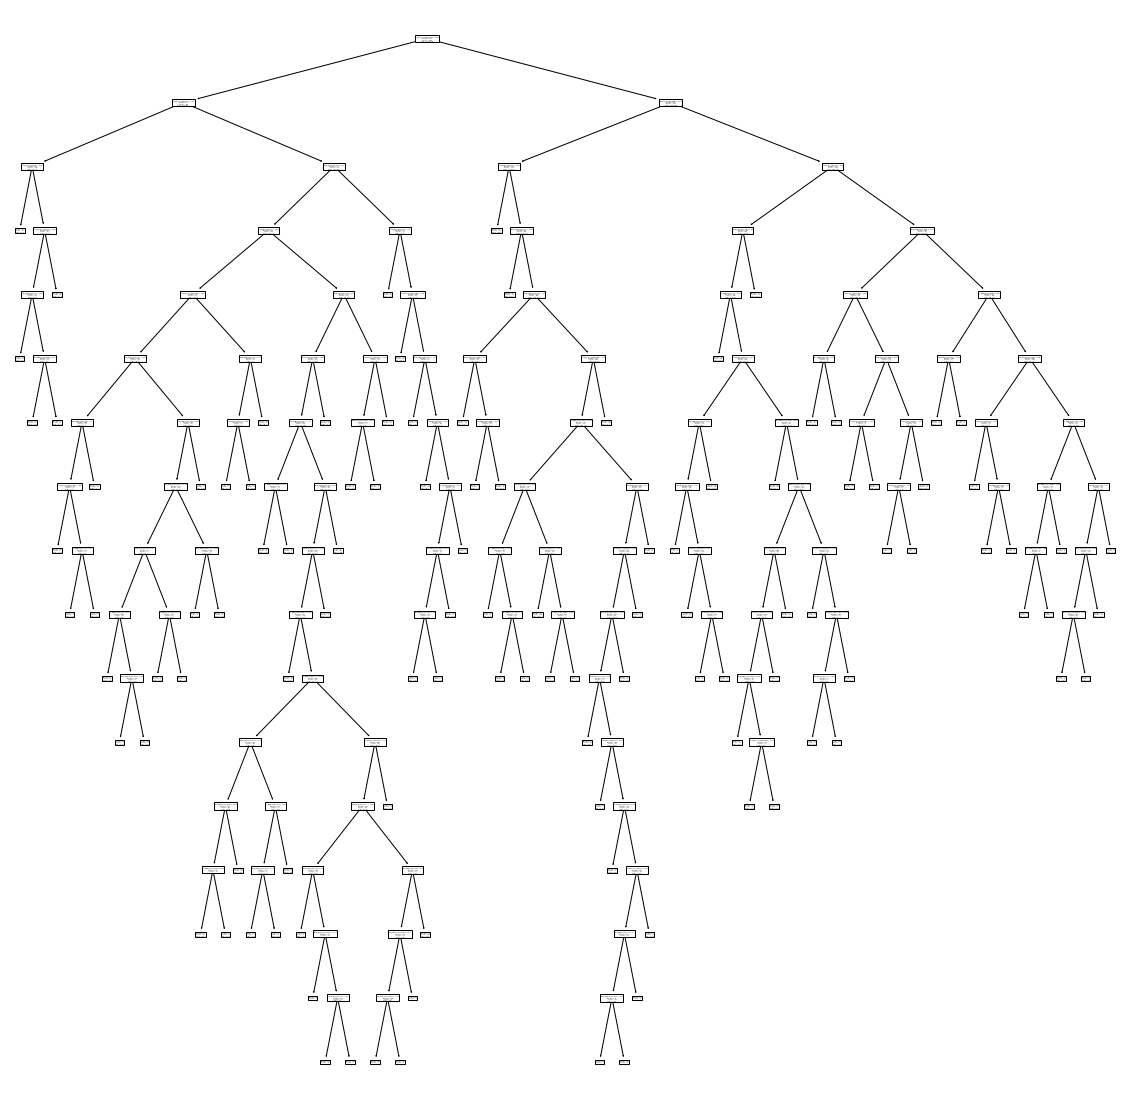

In [762]:
print(values)
print(parameters)

clf = DecisionTreeClassifier(criterion="entropy",max_depth=16,max_features = 'log2',min_samples_split=2)
clf.fit(X_train,y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(clf,feature_names = X.columns)
plt.savefig('tree.png')
plt.show()

### Random Forest Classifier

In [763]:
clf = RandomForestClassifier() 
parameters = [{'criterion': ["gini","entropy"],'max_depth' : [2**i for i in range(1,8)],
              'min_samples_split' : [2,5,10],'max_features' : ["sqrt","log2"],
               'bootstrap':[True,False],'random_state':[42]}]
values,parameters = nested_kfold_cv(clf,parameters,X_resampled,y_resampled,k1=10,k2=3)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_sa

In [764]:
print(values)
print(parameters)

[(0.9896907216494846, 0.96, 0.96579476861167), (1.0, 0.9823008849557522, 0.9857904085257548), (1.0, 0.990909090909091, 0.9927140255009108), (0.9805825242718447, 0.9901960784313726, 0.9882583170254403), (1.0, 0.9811320754716981, 0.9848484848484849), (1.0, 1.0, 1.0), (0.9907407407407407, 1.0, 0.9981343283582089), (1.0, 0.9629629629629629, 0.9701492537313433), (0.9902912621359223, 0.9807692307692307, 0.9826589595375723), (1.0, 1.0, 1.0)]
[{'bootstrap': False, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}, {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}, {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 5, 'random_state': 42}, {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'sqrt', 'min_samples_split': 2, 'random_state': 42}, {'bootstrap': False, 'criterion': 'entr

### Deployment

Support Vector machine trained on the whole dataset. 

In [767]:
svm_final_model = SVC(C=8,gamma=0.125,kernel = 'rbf')

svm_final_model.fit(X_resampled,y_resampled.values.ravel())

SVC(C=8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.125, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)